In [1]:
import torch
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
torch.manual_seed(42)

In [3]:
# check for gpu
device = torch.device('mps'  if torch.backends.mps.is_available() else 'cpu')
print(f"using: {device}")

using: mps


In [4]:
df = pd.read_csv('data/fashion-mnist_train.csv')
df

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59996,1,0,0,0,0,0,0,0,0,0,...,73,0,0,0,0,0,0,0,0,0
59997,8,0,0,0,0,0,0,0,0,0,...,160,162,163,135,94,0,0,0,0,0
59998,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


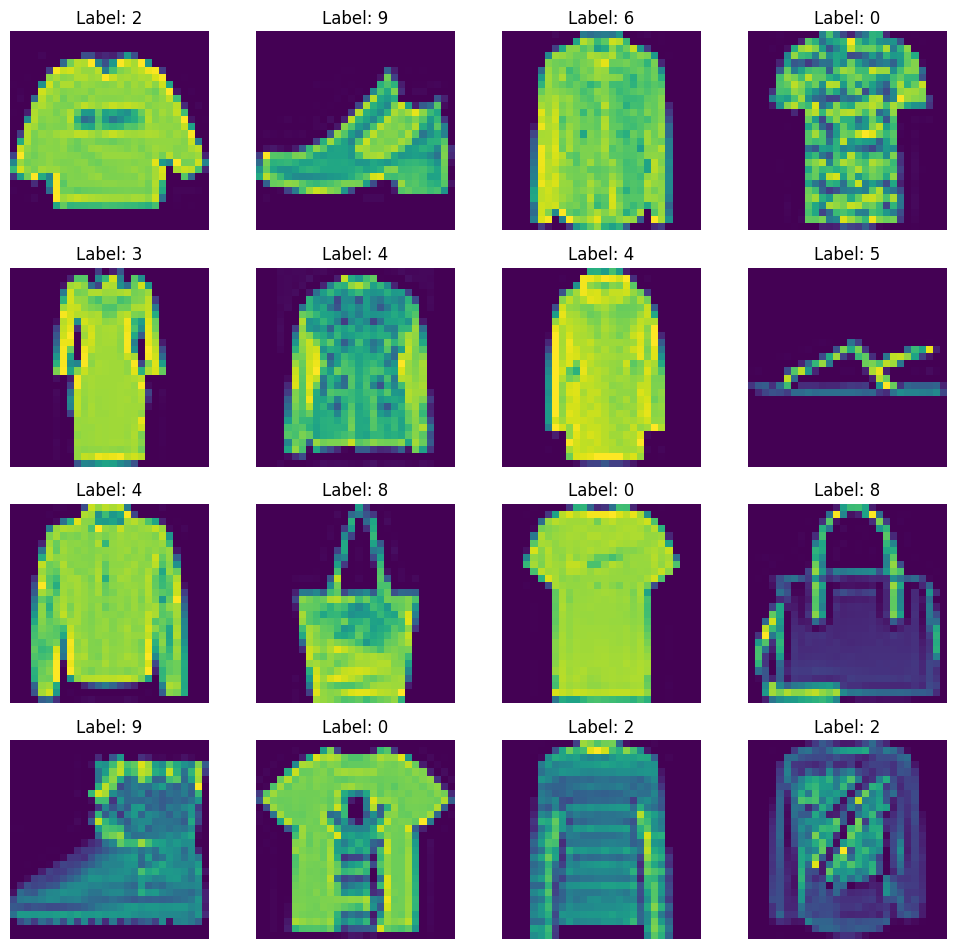

In [5]:
# create 4*4 grid of images
fig,axes = plt.subplots(4,4,figsize=(10,10))

#plot the first 16 images from the dataset
for i, ax in enumerate(axes.flat):
    img = df.iloc[i,1:].values.reshape(28,28)
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(f"Label: {df.iloc[i,0]}")

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [6]:
X = df.iloc[:,1:].values
y = df.iloc[:,0].values

In [7]:
# train test split 
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
# scaling the features
x_train = x_train/255.0
x_test = x_test/255.0

In [9]:
class CustomDataset(Dataset):
    def __init__(self,features,labels):
        self.features = torch.tensor(features,dtype=torch.float32).reshape(-1,1,28,28)
        self.labels = torch.tensor(labels,dtype=torch.long)
    
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):
        return self.features[idx],self.labels[idx]      

In [10]:
train_dataset = CustomDataset(x_train,y_train)
test_dataset = CustomDataset(x_test,y_test)

In [11]:
train_loader = DataLoader(dataset=train_dataset,batch_size=32,shuffle=True,pin_memory=True)
test_loader = DataLoader(dataset=test_dataset,batch_size=32,shuffle=False,pin_memory=True)

In [13]:
class MYCnn(nn.Module):
    def __init__(self,input_features):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(input_features,32,kernel_size=3,padding='same'),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=2,stride=2),
            nn.Conv2d(32,64,kernel_size=3,padding='same'),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2,stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64*7*7,128),
            nn.ReLU(),
            nn.Dropout(0.4),
            
            nn.Linear(128,64),
            nn.ReLU(),
            nn.Dropout(0.4),
             
            nn.Linear(64,10),
        )
    
    def forward(self, x):
        x =self.features(x)
        x = self.classifier(x)
        return x

### **Summary of the Architecture (With Proper Understanding)**

1. **Input**: 
   - Starts with an RGB image of shape \((N, 3, H, W)\), e.g., \((1, 3, 64, 64)\) for one \(64 \times 64\) image.

2. **First Block**: 
   - **Conv2d (3 → 32)**:  
     - The input has 3 channels (R, G, B).  
     - **32 kernels** (each 3 * 3 * 3) extract features by looking at all 3 channels.  
     - Produces **32 feature maps**, so the output shape becomes \((1, 32, 64, 64)\).  
   - **ReLU**: Introduces non-linearity to the feature maps.  
   - **BatchNorm2d (32)**: Normalizes the 32 feature maps for stable training.  
   - **MaxPool2d**: Halves the spatial dimensions, reducing the output shape to \((1, 32, 32, 32)\).  

3. **Second Block**: 
   - **Conv2d (32 → 64)**:  
     - The **input now has 32 channels**, which come from the 32 feature maps generated by the first convolution.  
     - **64 kernels** (each \(3 \times 3 \times 32\)) learn to extract deeper features from these 32 input channels.  
     - Produces **64 feature maps**, so the output shape becomes \((1, 64, 32, 32)\).  
   - **ReLU**: Again, adds non-linearity to the deeper features.  
   - **BatchNorm2d (64)**: Normalizes the 64 feature maps.  
   - **MaxPool2d**: Halves the spatial dimensions again, reducing the output shape to \((1, 64, 16, 16)\).  

---

### Key Points :
- After the **first convolution**, the 3 input channels (R, G, B) are expanded to **32 feature maps (channels)**.  
- In the **second convolution**, these **32 channels** become the **input** for 64 filters, each of which looks at all 32 channels to learn more complex features.  



In [14]:
learning_rate = 0.1
epochs = 100

In [15]:
model = MYCnn(1).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate,weight_decay=1e-4)

In [16]:
# training loop
for epoch in range(epochs):
    
    total_epoch_loss = 0
    for batch_features , batch_labels in train_loader:
        
        # move data to GPU
        batch_features = batch_features.to(device)
        batch_labels = batch_labels.to(device)
        
        # forward pass
        outputs = model(batch_features)
        
        # calculate loss
        loss = criterion(outputs,batch_labels)
        
        # backprop
        optimizer.zero_grad()
        loss.backward()
        
        # update parameters
        optimizer.step()
        
        total_epoch_loss += loss.item()
    
    avg_loss = total_epoch_loss / len(train_loader)
    print(f'Epoch {epoch+1}, Loss: {avg_loss}')
    

Epoch 1, Loss: 0.5850534182985624
Epoch 2, Loss: 0.4068483492285013
Epoch 3, Loss: 0.3480337749893467
Epoch 4, Loss: 0.3075542352323731
Epoch 5, Loss: 0.2819638335282604
Epoch 6, Loss: 0.2562350563754638
Epoch 7, Loss: 0.2410438656906287
Epoch 8, Loss: 0.22722327611067641
Epoch 9, Loss: 0.21127346067130565
Epoch 10, Loss: 0.19992373555153609
Epoch 11, Loss: 0.18729119872053465
Epoch 12, Loss: 0.18242957331240178
Epoch 13, Loss: 0.1756614233860746
Epoch 14, Loss: 0.17281870787839096
Epoch 15, Loss: 0.16521015238777423
Epoch 16, Loss: 0.16211753194686027
Epoch 17, Loss: 0.15105527882371098
Epoch 18, Loss: 0.14551836005132646
Epoch 19, Loss: 0.14312271183996927
Epoch 20, Loss: 0.13988954415063684
Epoch 21, Loss: 0.13357453403109684
Epoch 22, Loss: 0.13165521691258375
Epoch 23, Loss: 0.12816127481202905
Epoch 24, Loss: 0.1238006191944393
Epoch 25, Loss: 0.11986361637509739
Epoch 26, Loss: 0.11975456808953701
Epoch 27, Loss: 0.11894141460823206
Epoch 28, Loss: 0.10821212277126808
Epoch 29, 

In [17]:
model.eval()

MYCnn(
  (features): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (5): ReLU()
    (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=3136, out_features=128, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): ReLU()
    (6): Dropout(p=0.4, inplace=False)
    (7): Linear(in_features=64, out_features=10, bias=True)
  )
)

In [18]:
# evaluation 
total = 0
correct = 0
with torch.no_grad():
    for batch_features , batch_labels in test_loader:
        # move data to GPU
        batch_features = batch_features.to(device)
        batch_labels = batch_labels.to(device)
        
        
        outputs = model(batch_features)
        _,predicted = torch.max(outputs,1)
        total += batch_labels.shape[0]
        correct += (predicted==batch_labels).sum().item()
        
print(correct/total)

0.9224166666666667
